# Mini-1 

**Name:** *Ashutosh Kumar*  
**Course:** EECS 590 Reinforcement Learning  
**Mini 1_Solution**

In this notebook I work through all 8 tasks from Mini-1:

1. Come up with a practical idea for recording ideas and questions.  
2. Build simple classes for finite Markov processes and Markov reward processes.  
3. Method for value convergence to solve the Bellman equation two ways and look at convergence.  
4. Turn 2D masks such as given into gridworld MRPs.  
5. Discuss and play with different discount factors \\( \gamma \\) and see what actually changes.  
6. Add actions and do a basic policy evaluation on a gridworld.  
7. Sketch how to tile small grids into larger worlds without huge tensors.  
8. Write down some thoughts on where the Markov model is nice and where it feels limiting.

## Task 1 — A way to keep track of ideas / confusions / questions / plans

There are a lot of moving parts already: states, rewards, transitions, Markov property, returns, Bellman equations…  
If I don’t write things down, I forget *what* I was confused about.

I decided to use a small “lab-note” template for each new concept or slide cluster:

### note template

For each topic I fill in:

1. **Name of the concept**  
2. **Definition in my own words**  
3. **Key equation(s)** + what the symbols mean  
4. **Intuition / story** (how it fits in the RL loop)  
5. **Tiny example** (numbers or a small grid)  
6. **Failure modes / edge cases**  
7. **Implementation notes** (data structures, numerical stuff)  
8. **Next action** (one concrete thing to code or check)

Below are two example entries I actually used while working on this mini.

### For Example

- **Name of the concept**  Discounted return

- **Definition:** The discounted return from time \\(t\\) is the total future reward, but each step into the future gets multiplied by \\( \gamma \\).  
- **Equation:**  
  \\[
  G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}.
  \\]
- **Intuition:** If \\( \gamma \\) is small I only care about the near future; if it’s close to 1 then far-future rewards still matter a lot.  
- **Edge case:** With \\( \gamma = 1 \\) and an infinite-horizon process, this sum can blow up.  
- **Note to self:** Use \\( \gamma < 1 \\) for continuing MRPs unless the the project or assignment explicitly wants \\( \gamma = 1 \\).  
- **Next action:** Change \\( \gamma \\) in the gridworld and watch how the value heatmap changes.



## Task 2 — Classes for finite Markov processes and Markov reward processes (MRPs)

Here I introduce two small classes:

- `FiniteMarkovProcess` — just states + a transition matrix \\(P\\).  
- `FiniteMRP` — extends that with a reward vector \\(R\\) and a discount factor \\( \gamma \\).

I represent \\(P\\) as a SciPy sparse CSR (compressed sparse row) matrix. In gridworlds each state only connects to a few neighbours, so spending memory on a dense \\(n \times n\\) matrix doesn’t make sense.

Key checks I do in `validate()`:

- Each non-empty row of \\(P\\) sums to 1 (row-stochastic).  
- The reward vector has the right length.  
- \\( \gamma \\) is in \\([0, 1]\\).

The `FiniteMRP` class also has:

- `bellman_equaation(V)` implementing \\( R + \gamma P V \\)  
- `value_iteration(...)` that repeatedly applies the backup and tracks convergence  
- `solve_linear_system()` which solves \\((I - \gamma P)V = R\\) with sparse linear algebra

So later tasks can just build an MRP and call these methods instead of re-implementing the math each time.

In [60]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(0)

In [62]:
from dataclasses import dataclass # Keeps the class definition short and readable
from typing import Dict, Tuple, List, Any, Optional #type hints. They are not required for Python to run but help our editor/IDE (VS Code, PyCharm) catch bugs,
@dataclass #I am using this decorator instead of __init__ as with this python autogenerate many constructor
class FiniteMarkovProcess:
    #This class represents a finite Markov process with state set S and transition matrix P.
    """ Finite Markov Process (S,P). """
    states: List[Any] # I am not pinning down the exact state type.
    P: sp.csr_matrix # this is transition matrix P, CSR format only stores non-zeros → big memory savings.
    def n_states(self) -> int:
        return len(self.states)

    def validate_row_stochastic(self,tol:float =1e-9) -> None:
        row_sums = np.asarray(self.P.sum(axis=1)).ravel() # summing along column to get one sum per row
        nonzero_rows = row_sums > tol #ignoring empty rows
        max_err = np.max(np.abs(row_sums[nonzero_rows] - 1.0)) if np.any(nonzero_rows) else 0.0 #compute maximum error
        if max_err > 1e-6:
            raise ValueError(f"Transition matrix rows not stochastic enough. max_err={max_err}") #checking if error is too big

    def next_state_distribution(self, s_idx:int) -> Dict[int, float]:
        row = self.P.getrow(s_idx) #to return the sparse row object
        return {int(c): float(p) for c, p in zip(row.indices, row.data)} #row.indices --> build a dir to give me columns where we have non-zero values and row.data --> gives me the values
          
# Mathematically, above code is implementing the object: (𝑆,𝑃)(S,P): a finite Markov process 
#===================================================================================================================================================
@dataclass
class FiniteMRP(FiniteMarkovProcess): #inherits from class FiniteMarkovProcess so already has states, P and other methods like n_states() etc.
    """Finite Markov Reward Process (S, P, R, gamma)."""
    R: np.ndarray #adding reward vector 
    gamma: float  #discount factor we will use between 0 to 1

    def validate(self) -> None: # adding for sanity check only and to ensure accuracy for MRP is defined correct
        if not(0.0 <= self.gamma <=1.0):
            raise ValueError("gamma must be in [0,1].") # if we accidently use value for gamma outside 0 and 1 it will raise error
        if self.R.shape != (self.n_states(),):
            raise ValueError("R must have shape (n_states,)).") # this is to ensure the shape of states n and Rewards R are same
        self.validate_row_stochastic()     #inherited method from previous class that checks P
    def bellman_equation(self, V:np.ndarray) -> np.ndarray:
        return self.R +self.gamma * (self.P @ V) #core bellman equation code for V = R + gamma PV

    def value_iteration(self, tol: float = 1e-10, max_iter: int = 50_000, V0: Optional[np.ndarray] = None): #implementing valu iteration for MRPs
        n= self.n_states()
        V = np.zeros(n) if V0 is None else V0.copy() #starting V with 0 or provided values if any
        deltas = []  #to store how much V changes from one iteration to next 
        snapshots = [] # just to store copies of V, I am planning to use this for animation of plot
        for _ in range(max_iter): #main loop
            snapshots.append(V.copy())
            V_new = self.bellman_equation(V) #apply bellman
            delta = np.max(np.abs(V_new - V)) #maximum absolute chnage calculation
            deltas.append(delta)
            V = V_new  #update the current value funct
            if delta < tol :  # to stop once we think we are close enough to true solution
                snapshots.append(V.copy())
                break
        return V, np.array(deltas), snapshots
        
    def solve_linear_system(self):
        n = self.n_states()
        A = sp.eye(n, format = 'csr') -self.gamma * self.P #using sp.eye from scipy lib to create n x n identity matrix in sparse form
        try:
            V = spla.spsolve(A, self.R)
            return np.asarray(V), {"method" : "spsolve", "converged": True}
        except Exception:
            V, exit_code = spla.gmres(A, self.R, atol = 0, tol = 1e-10, restart=200, maxiter = 10_000)
            return np.asarray(V), {"method" : "gmres", "converged": exit_code == 0, "exit_code": exit_code}  #gmres is used on class slide too
 #referance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html  
 # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html   

## Task 3 — Solving the Bellman equation and watching convergence

In the class slides the Bellman equation for an MRP is
\\[
V(s) = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1}) \mid S_t = s]
\quad\Longleftrightarrow\quad
V = R + \gamma P V.
\\]

In this task I will:

1. Build the 5×5 “Mini-1” gridworld from the mask.  
2. Compute \\(V\\) with **value iteration** and with a **linear solve**, and check they agree.  
3. Plot the convergence curve.  
4. Make a small animation that shows the value function changing over iterations.


In [63]:
#visualization helpers
def plot_grid(values_2d: np.ndarray, title: str = "", show_numbers: bool = False):
    grid = values_2d.copy().astype(float) #copying and ensuring values are float
    grid[np.isneginf(grid)] = np.nan #using negative infinity for wall or invalid cells to avoid coloring in plots
    plt.figure(figsize=(6, 6))
    plt.imshow(grid) # to show the array as heatmap in 6*6 inch figure
    plt.title(title)
    plt.xticks(range(grid.shape[1]))
    plt.yticks(range(grid.shape[0]))
    plt.colorbar()
    if show_numbers:
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if np.isfinite(values_2d[i, j]):
                    plt.text(j, i, f"{values_2d[i,j]:.1f}", ha="center", va="center", fontsize=8)
    plt.show()

def build_mrp_from_mask(mask: np.ndarray, gamma: float):
    H, W = mask.shape  #height and weidth of the grid
    valid = np.isfinite(mask) #boolean array, True whne mast is finite or real number and False where mast in NaN or +-inf

    states = []
    state_to_idx: Dict[Tuple[int,int], int] = {}
    for i in range(H):
        for j in range(W):
            if valid[i, j]:
                state_to_idx[(i, j)] = len(states)
                states.append((i, j))

    n = len(states)
    R = np.array([mask[i, j] for (i, j) in states], dtype=float) #building the reward vector R

    rows, cols, data = [], [], []   #prepare to build transition matrix
    def neighbors(i, j): #function to find neighbors
        for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]: # we are considering four directions Up (-1,0), down (1,0), left (0,-1), right (0,1)
            ni, nj = i+di, j+dj #check for new coordinates or neighbor
            if 0 <= ni < H and 0 <= nj < W and valid[ni, nj]: #check if they are inside the grid and valid (not a wall or inf)
                yield (ni, nj) #yield as valid neighbor state

    for s_idx, (i, j) in enumerate(states): #loop over all states
        nbrs = list(neighbors(i, j)) #find neighbor
        if len(nbrs) == 0: #invalid neighbor
            rows.append(s_idx); cols.append(s_idx); data.append(1.0)
        else:
            p = 1.0 / len(nbrs) #assign equal probability to each neighbor
            for (ni, nj) in nbrs:
                rows.append(s_idx) #current state
                cols.append(state_to_idx[(ni, nj)]) #to neighbor
                data.append(p) #the probability

    P = sp.csr_matrix((data, (rows, cols)), shape=(n, n)) #builds the sparse transition matrix P
    mrp = FiniteMRP(states=states, P=P, R=R, gamma=gamma) #construct finite MRP
    mrp.validate()
    return mrp, state_to_idx

def values_to_grid(mask: np.ndarray, state_to_idx: Dict[Tuple[int,int], int], V: np.ndarray):
    out = np.full(mask.shape, np.nan, dtype=float) #Create a 2D array out with the same shape as the mask.
    for (i, j), idx in state_to_idx.items():
        out[i, j] = V[idx]
    return out


### 3.1  The 5×5 grid from the mini

This is the mask from the mini (walls are \\(-\infty\\)). I treat every finite cell as a state, use the mask entry as the state reward, and give each state equal probability to move to any valid 4-neighbour.

So;

- The environment is a 5×5 grid.

- Some squares are valid states with different rewards.

- The -np.inf squares are blocked.

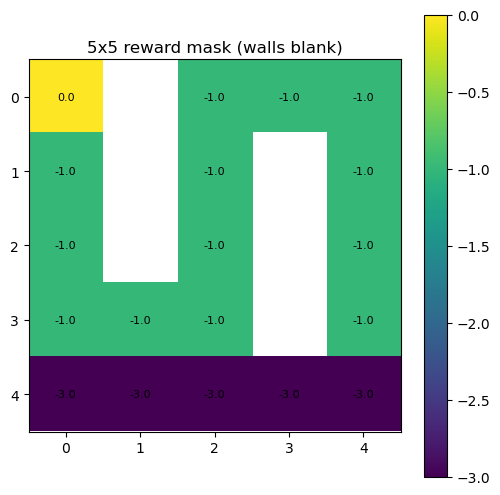

19

In [70]:

mask_5x5 = np.array([
    [ 0.,   -np.inf, -1.,  -1.,  -1. ],
    [-1.,   -np.inf, -1.,  -np.inf, -1.],
    [-1.,   -np.inf, -1.,  -np.inf, -1.],
    [-1.,   -1.,     -1.,  -np.inf, -1.],
    [-3.,   -3.,     -3.,  -3.,    -3.]
], dtype=float)

plot_grid(mask_5x5, title="5x5 reward mask (walls blank)", show_numbers=True)

mrp_5x5, st2i_5x5 = build_mrp_from_mask(mask_5x5, gamma=0.95)
mrp_5x5.n_states()

Linear solver info: {'method': 'spsolve', 'converged': True}
max |V_vi - V_ls| = 1.737987531669205e-11


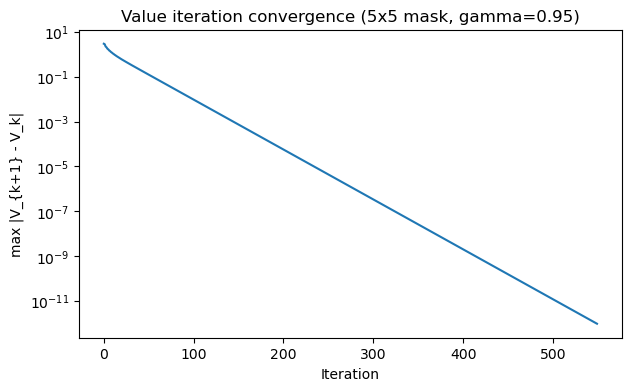

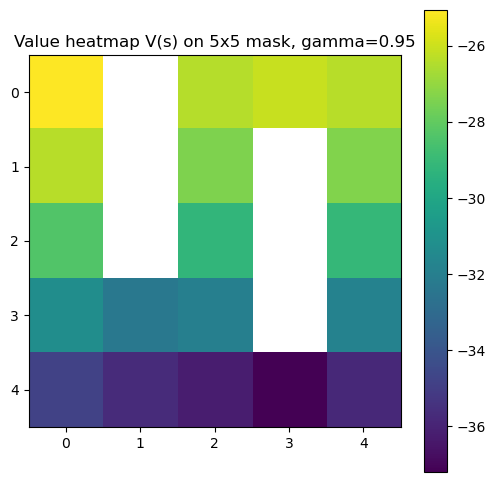

In [65]:
V_vi_5x5, deltas_5x5, snaps_5x5 = mrp_5x5.value_iteration(tol=1e-12, max_iter=20000)
V_ls_5x5, info_5x5 = mrp_5x5.solve_linear_system()

print("Linear solver info:", info_5x5)
print("max |V_vi - V_ls| =", np.max(np.abs(V_vi_5x5 - V_ls_5x5)))

plt.figure(figsize=(7,4))
plt.plot(deltas_5x5) # tracking how much the value function is changing over time
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("max |V_{k+1} - V_k|")
plt.title("Value iteration convergence (5x5 mask, gamma=0.95)")
plt.show()

plot_grid(values_to_grid(mask_5x5, st2i_5x5, V_vi_5x5), title="Value heatmap V(s) on 5x5 mask, gamma=0.95")


The maximum difference between the iterative solution and the linear solve is basically numerical noise, which is a nice sanity check that my implementation matches the math.

The log-scale convergence plot also makes the Banach fixed-point idea feel more real: the error shrinks roughly geometrically until it hits machine precision.


### 3.2  Animated convergence on the 5×5 grid

To see what the Bellman updates are actually doing, I store the intermediate \\( V_k \\) values from value iteration and turn them into a short animation. Each frame is a heatmap of the current value function.

The frames below are subsampled (I only keep every Nth iteration) so that the animation doesn’t get too long.


In [71]:
from matplotlib.animation import FuncAnimation  # ref: https://matplotlib.org/stable/api/animation_api.html
from IPython.display import HTML

# Use ALL snapshots so we see every iteration
frames_all = [values_to_grid(mask_5x5, st2i_5x5, V) for V in snaps_5x5]

# Compute global color scale from all frames (so differences are visible)
all_vals = np.concatenate([
    f[np.isfinite(f)].ravel() for f in frames_all
])
vmin, vmax = all_vals.min(), all_vals.max()

# If too many frames, subsample to ~50 for nicer playback
step = max(1, len(frames_all) // 50)
frames = frames_all[::step]

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frames[0], vmin=vmin, vmax=vmax)
ax.set_title("Value iteration heatmap (5x5)")
ax.set_xlabel("Iteration ~ 0")

def update(frame_idx):
    im.set_array(frames[frame_idx])
    ax.set_xlabel(f"Iteration ~ {frame_idx * step}")
    return (im,)

anim = FuncAnimation(fig, update, frames=len(frames), interval=200, blit=False)
plt.close(fig)

HTML(anim.to_jshtml())


## Task 4 — Turning masks into gridworld MRPs

The helper `build_mrp_from_mask` is my general use function here:

- **States:** all coordinates where the mask value is finite.  
- **Reward:** `R(s) = mask[i, j]` for state `(i, j)`.  
- **Transitions:** from each state we move uniformly to all valid 4-neighbours. If a state has no valid neighbours, we make it absorbing.

To play with something a bit more interesting than the 5×5, I built a 10×10 mask with:

- Border walls  
- An interior “box” of walls with doors  
- A big goal state, a smaller positive state, and a couple of nasty negative states  
- A “mud” patch with medium negative reward  
- A small step penalty of −0.1 everywhere else

Once I have this mask, I just feed it into `build_mrp_from_mask` and use the MRP methods from Task 2.



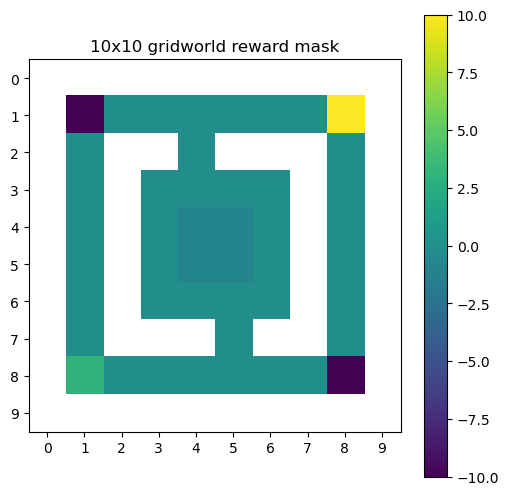

46

In [72]:

def make_10x10_mask() -> np.ndarray:
    H, W = 10, 10 #height and width of the grid 
    mask = np.full((H, W), -0.1, dtype=float) create 10 x 10 array with -0.1 as step penalty everywhere
    wall = -np.inf # using negative infinity for wall marker
    mask[0, :] = wall #top row (row 0)
    mask[-1, :] = wall #bottom row (row 9)
    mask[:, 0] = wall #left column (column 0)
    mask[:, -1] = wall# right column (column 9)
    mask[2, 2:8] = wall # row 2 column 2,3,4,5,6,7 for wall
    mask[7, 2:8] = wall
    mask[3:7, 2] = wall
    mask[3:7, 7] = wall
    mask[2, 4] = -0.1 #rewards
    mask[7, 5] = -0.1 
    mask[1, 8] = +10.0 #good spot for agent
    mask[8, 1] = +3.0
    mask[1, 1] = -10.0 #bad spot for agent
    mask[8, 8] = -10.0
    mask[4:6, 4:6] = -1.0
    return mask

mask_10x10 = make_10x10_mask()
plot_grid(mask_10x10, title="10x10 gridworld reward mask", show_numbers=False)

mrp_10x10, st2i_10x10 = build_mrp_from_mask(mask_10x10, gamma=0.95)
mrp_10x10.n_states()


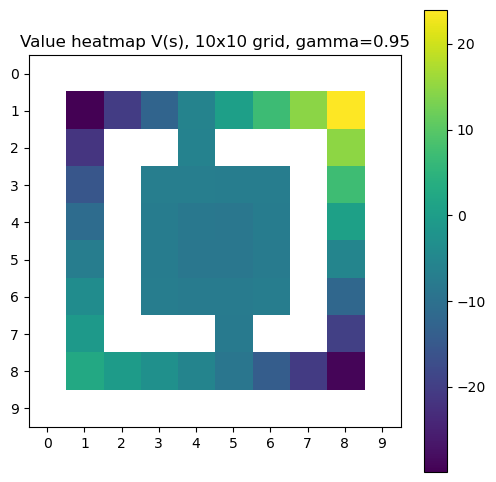

In [73]:
#doing same for 10 x 10 world what we did previously for 5 x 5 grid world
V_vi_10, deltas_10, snaps_10 = mrp_10x10.value_iteration(tol=1e-12, max_iter=20000)
plot_grid(values_to_grid(mask_10x10, st2i_10x10, V_vi_10), title="Value heatmap V(s), 10x10 grid, gamma=0.95")


## Task 5 — What does the discount factor \\( \gamma \\) actually do?

Here I keep the same 10×10 world but vary \\( \gamma \\) and see what happens.

For each \\( \gamma \\in \{0.0, 0.5, 0.9, 0.95, 0.99\} \\) I:

1. Build the corresponding MRP.  
2. Run value iteration until convergence.  
3. Plot the convergence curve.  
4. Plot the value heatmap.

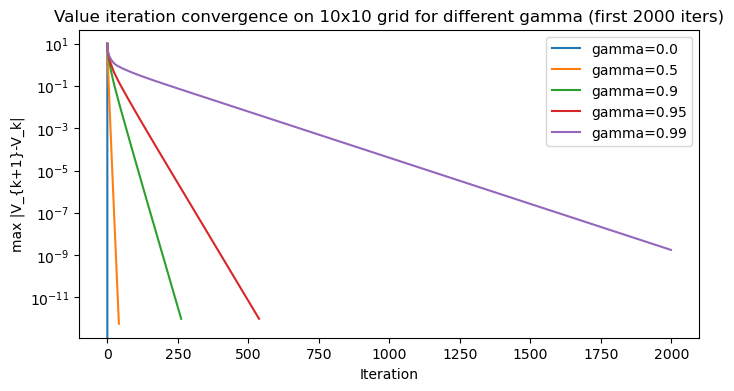

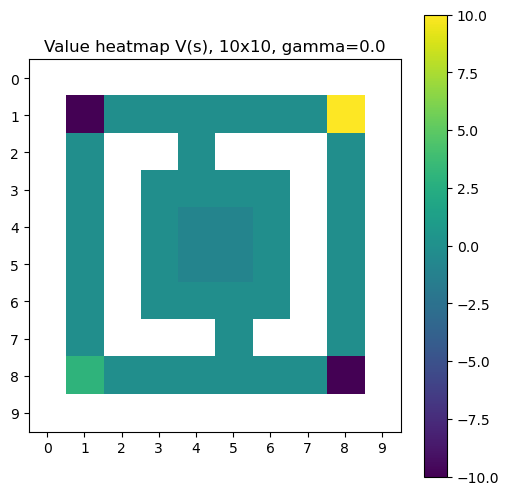

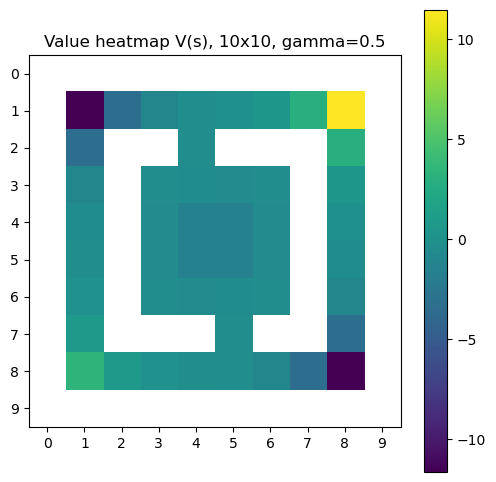

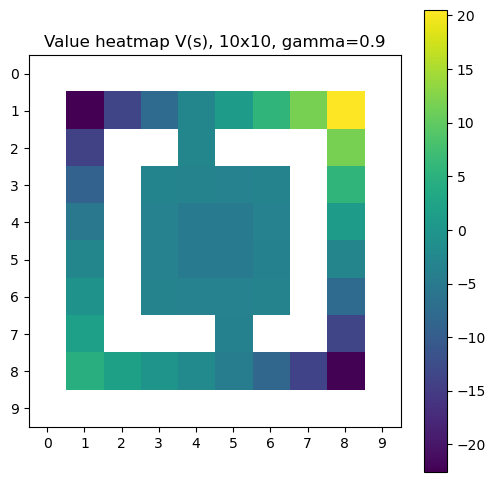

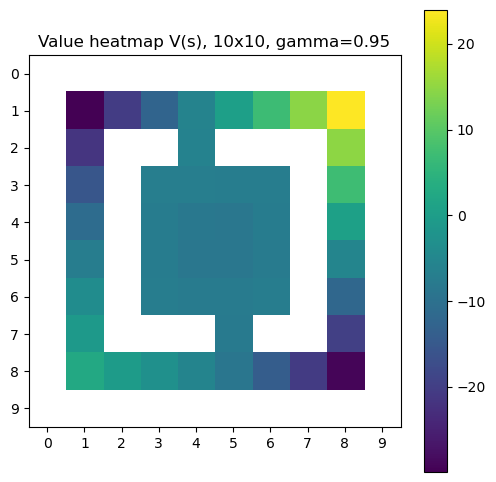

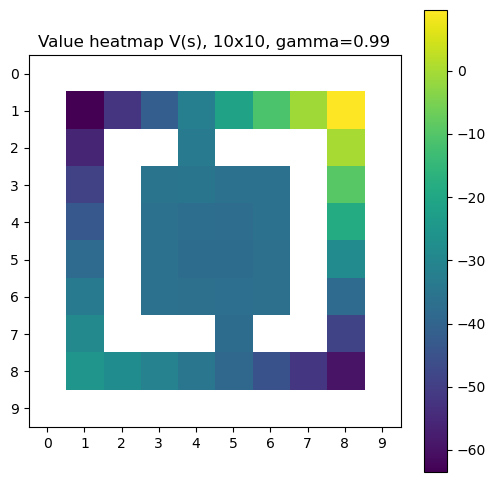

In [75]:
gammas = [0.0, 0.5, 0.9, 0.95, 0.99]  #list of discount factors
results_10 = {}

for g in gammas:  #the loop i am using to build new MRP for each gamma and run value iteration
    mrp_g, st2i_g = build_mrp_from_mask(mask_10x10, gamma=g)  # Same mask_10x10 → same states, transitions, rewards only gamma is changing
    Vg, deltas_g, snaps_g = mrp_g.value_iteration(tol=1e-12, max_iter=50000)
    results_10[g] = (mrp_g, st2i_g, Vg, deltas_g)

plt.figure(figsize=(8,4))
for g in gammas:
    deltas_g = results_10[g][3]
    plt.plot(deltas_g[:2000], label=f"gamma={g}")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("max |V_{k+1}-V_k|")
plt.title("Value iteration convergence on 10x10 grid for different gamma (first 2000 iters)")
plt.legend()
plt.show()

for g in gammas:  
    _, st2i_g, Vg, _ = results_10[g]
    plot_grid(values_to_grid(mask_10x10, st2i_g, Vg), title=f"Value heatmap V(s), 10x10, gamma={g}")


Some quick observations I saw in the plots:

- **\\( \gamma = 0.0 \\)**  
  Values basically equal the immediate reward. Long-term consequences don’t matter at all.

- **\\( \gamma = 0.5 \\)**  
  Only rewards a few steps away have a noticeable effect. The influence of the goal and traps dies off pretty quickly as you move away.

- **\\( \gamma = 0.9 \\) and above**  
  The goal and bad states “pull” or “push” value over a much wider region. States that are many steps away already see a strong positive or negative value.

- As \\( \gamma \\) gets closer to 1, the magnitude of values grows and the landscape looks smoother because far-future rewards are hardly discounted.

On the convergence side:

- For smaller \\( \gamma \\), the contraction is stronger and value iteration converges in fewer iterations.  
- For \\( \gamma = 0.99 \\) it still converges, but the error curve decays much more slowly.

## Task 6 — Adding actions and evaluating a simple policy

Up to now everything has been “passive”: the agent just drifts around according to \\(P\\). To get closer to RL we need **actions**.

For the 10×10 grid I add four actions:

- `U` (up), `D` (down), `L` (left), `R` (right).

For each action I build a deterministic transition matrix \\(P^a\\): it tries to move in that direction, but if the move would hit a wall or leave the grid, the agent stays where it is.

Then I define a simple **greedy policy**:

- At each state, pick the action that most reduces Manhattan distance to the goal at `(1, 8)` (breaking ties arbitrarily).

From this policy I get an induced MRP with

\\[
P^\pi(s' \mid s) = P(s' \mid s, a = \pi(s)),
\\]

and then I just run the same value iteration code as before to get \\( V^\pi \\).

The resulting value heatmap shows which states are “good” under this particular policy (not under the optimal policy in general). The convergence plot looks similar to the earlier MRPs, but now it’s explicitly “policy evaluation.”



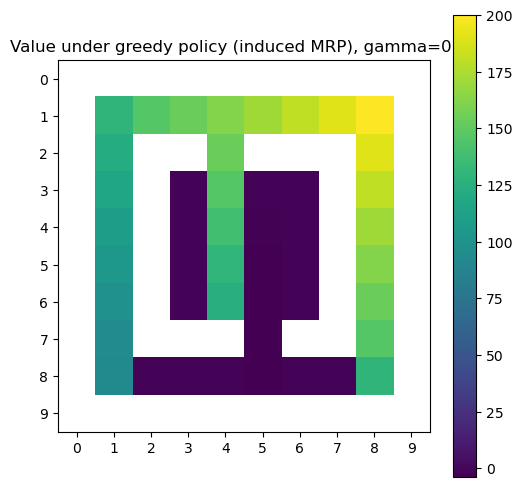

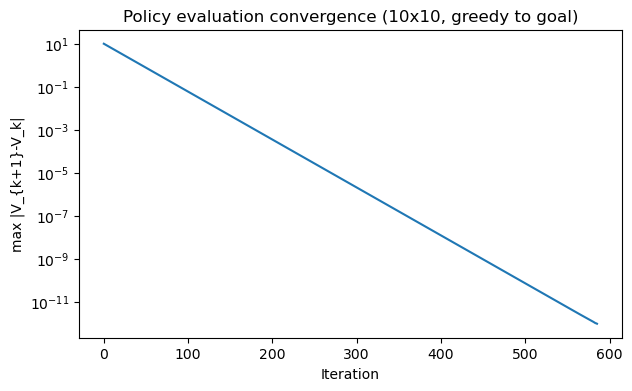

In [58]:
ACTIONS = ["U", "D", "L", "R"] # setting up the actions that an agent can take
ACTION_DELTAS = {"U":(-1,0), "D":(1,0), "L":(0,-1), "R":(0,1)} #how action chnages grid coordinates

def build_grid_mdp_transitions(mask: np.ndarray):  #building Markov decision process transition matrix for each action
    H, W = mask.shape
    valid = np.isfinite(mask)
    states, st2i = [], {}
    for i in range(H):
        for j in range(W):
            if valid[i, j]:
                st2i[(i, j)] = len(states)
                states.append((i, j))
    n = len(states)
    P_a = {}
    for a in ACTIONS:  #transition matrix for each action
        di, dj = ACTION_DELTAS[a]
        rows, cols, data = [], [], []
        for s_idx, (i, j) in enumerate(states):
            ni, nj = i + di, j + dj
            if 0 <= ni < H and 0 <= nj < W and valid[ni, nj]: #check inside the gid and valid movement
                s2 = st2i[(ni, nj)]  #next state index
            else:
                s2 = s_idx  # stay in same index
            rows.append(s_idx); cols.append(s2); data.append(1.0)
        P_a[a] = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    return states, st2i, P_a

def greedy_policy_toward_goal(states, goal):
    pi = {}
    for idx, (i, j) in enumerate(states):
        best_a, best_dist = None, None
        for a in ACTIONS:
            di, dj = ACTION_DELTAS[a]
            ni, nj = i + di, j + dj
            dist = abs(goal[0] - ni) + abs(goal[1] - nj) 
            if best_dist is None or dist < best_dist:
                best_dist = dist
                best_a = a
        pi[idx] = best_a
    return pi

states_mdp, st2i_mdp, P_a_10 = build_grid_mdp_transitions(mask_10x10)
goal_10 = (1, 8)
pi_10 = greedy_policy_toward_goal(states_mdp, goal_10)

n = len(states_mdp)
rows, cols, data = [], [], []
for s_idx in range(n):
    a = pi_10[s_idx]
    row = P_a_10[a].getrow(s_idx)
    for c, p in zip(row.indices, row.data):
        rows.append(s_idx); cols.append(int(c)); data.append(float(p))
P_pi_10 = sp.csr_matrix((data, (rows, cols)), shape=(n, n))

gamma_pi = 0.95
R_pi_10 = np.array([mask_10x10[i, j] for (i, j) in states_mdp], dtype=float)
mrp_pi_10 = FiniteMRP(states=states_mdp, P=P_pi_10, R=R_pi_10, gamma=gamma_pi)
mrp_pi_10.validate()

V_pi_10, deltas_pi_10, snaps_pi_10 = mrp_pi_10.value_iteration(tol=1e-12, max_iter=20000)
plot_grid(values_to_grid(mask_10x10, st2i_mdp, V_pi_10), title="Value under greedy policy (induced MRP), gamma=0.95")

plt.figure(figsize=(7,4))
plt.plot(deltas_pi_10)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("max |V_{k+1}-V_k|")
plt.title("Policy evaluation convergence (10x10, greedy to goal)")
plt.show()

## Task 7 (optional) — Tiling grids without giant tensors

The mini mentions building more complicated worlds (trees of grids, etc.) and not wanting to commit to a huge 3D tensor upfront.

The rough idea I think is:

- Treat each small mask (e.g. 5×5) as its own MRP with local states and a local transition matrix.  
- Use a higher-level graph structure to say how tiles connect (e.g. a binary tree or chain).  
- Build a **block-sparse** global \\(P\\) where:
  - diagonal blocks are the internal transitions within each tile,  
  - a few off-diagonal blocks encode “portals” between tiles.

In the code I sketched a simple version that horizontally concatenates two 5×5 tiles using `scipy.sparse.block_diag`. A full tree-of-tiles version would keep stacking these blocks and wiring up portal edges, but the main point is: I can represent a big composite MRP as a sparse matrix over `(tile_id, local_state)` instead of as one huge 3D array.


In [59]:
def stitch_two_tiles_horizontally(mask_left: np.ndarray, mask_right: np.ndarray, gamma: float = 0.95):
    mrp_L, st2i_L = build_mrp_from_mask(mask_left, gamma) #building left tile MRP
    mrp_R, st2i_R = build_mrp_from_mask(mask_right, gamma) #building right tile MRP

    nL, nR = mrp_L.n_states(), mrp_R.n_states() # number of state count in left and right tile
    states = [("L", s) for s in mrp_L.states] + [("R", s) for s in mrp_R.states] #building combines state list for the stitched grid
    R = np.concatenate([mrp_L.R, mrp_R.R])  #concatinating reward vectors
    P_blocks = sp.block_diag([mrp_L.P, mrp_R.P], format="csr")
    stitched_mrp = FiniteMRP(states=states, P=P_blocks, R=R, gamma=gamma)
    stitched_mrp.validate()
    return stitched_mrp

stitched = stitch_two_tiles_horizontally(mask_5x5, mask_5x5, gamma=0.95)
stitched.n_states()


38

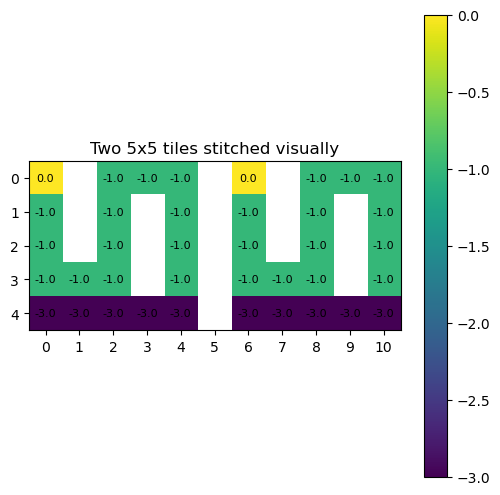

In [76]:
def make_stitched_mask_for_plot(mask_left: np.ndarray, mask_right: np.ndarray) -> np.ndarray:
    H1, W1 = mask_left.shape
    H2, W2 = mask_right.shape
    assert H1 == H2, "Heights must match for horizontal stitching"
    
    H, W = H1, W1 + 1 + W2  # +1 for a separator column
    stitched_mask = np.full((H, W), np.nan, dtype=float)
    
    # Left tile
    stitched_mask[:, :W1] = mask_left
    
    # Right tile, shifted by W1+1 columns
    stitched_mask[:, W1+1:] = mask_right
    
    return stitched_mask

#  with our 5x5
stitched_mask_5x10 = make_stitched_mask_for_plot(mask_5x5, mask_5x5)
plot_grid(stitched_mask_5x10, title="Two 5x5 tiles stitched visually", show_numbers=True)


In [78]:
def stitched_values_to_grid(stitched_mrp: FiniteMRP,
                            mask_left: np.ndarray,
                            mask_right: np.ndarray,
                            V: np.ndarray) -> np.ndarray:
    H1, W1 = mask_left.shape
    H2, W2 = mask_right.shape
    assert H1 == H2, "Heights must match"
    H, W = H1, W1 + 1 + W2  # separator column
    
    grid = np.full((H, W), np.nan, dtype=float)
    
    for idx, (side, (i, j)) in enumerate(stitched_mrp.states):
        if side == "L":
            # same coordinates for left tile
            grid[i, j] = V[idx]
        elif side == "R":
            # shift right tile by W1+1
            grid[i, j + W1 + 1] = V[idx]
        else:
            raise ValueError(f"Unknown side tag: {side}")
    
    return grid


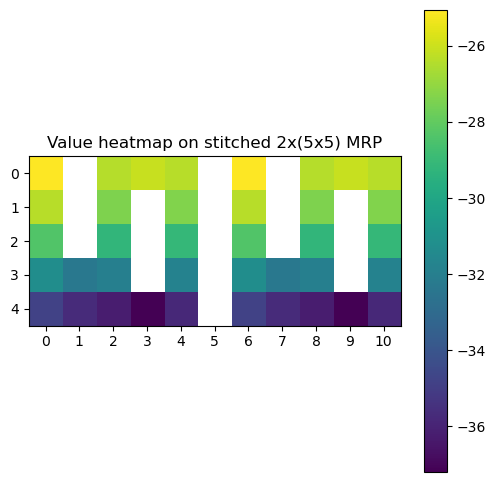

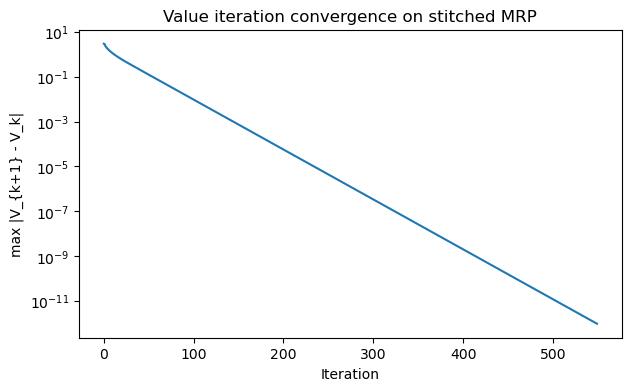

In [79]:
# 1. Build stitched MRP
stitched = stitch_two_tiles_horizontally(mask_5x5, mask_5x5, gamma=0.95)

# 2. Run value iteration on the stitched MRP
V_stitched, deltas_stitched, snaps_stitched = stitched.value_iteration(tol=1e-12, max_iter=20000)

# 3. Convert V to a 2D grid and plot
V_grid_stitched = stitched_values_to_grid(stitched, mask_5x5, mask_5x5, V_stitched)
plot_grid(V_grid_stitched, title="Value heatmap on stitched 2x(5x5) MRP", show_numbers=False)

# (Optional) Show convergence curve too
plt.figure(figsize=(7,4))
plt.plot(deltas_stitched)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("max |V_{k+1} - V_k|")
plt.title("Value iteration convergence on stitched MRP")
plt.show()


The plot  look like two copies of the original 5×5 value heatmap, side by side, with a blank column between.

Both halves have identical value patterns, because:

The left and right MRPs are copies (same mask, same gamma, same dynamics).

There are no transitions between them (block-diagonal P).

So visually, it’s like having two separate worlds sitting next to each other without any 3D initialization.

## Task 8 — Thoughts on the Markov model

After doing all of this in code, here’s how the Markov model feels to me.

### What I like

- **It’s extremely clean mathematically.**  
  Once the state is Markov and I know \\(P\\), \\(R\\), and \\( \gamma \\), the Bellman equation is just a linear system. The fixed-point view + the convergence plots make the Banach story feel very concrete.

- **The matrix / graph picture is intuitive.**  
  In the gridworlds I can literally see how rewards flow through the graph over iterations. The value heatmaps and the convergence animation helped more than just staring at equations.

- **It’s easy to experiment.**  
  Changing the mask or \\( \gamma \\) is like editing the environment and I immediately see the impact on \\(V\\).

### Where it feels limited

- **Real “state” is often not Markov.**  
  In many real problems I don’t observe the full state, just some noisy view of it. In that case the transition really depends on the hidden stuff, not just the observation, and the clean \\( V = R + \gamma P V \\) story is only approximate.

- **State spaces can explode.**  
  Even a 10×10 grid is tiny. As soon as I imagine richer features (inventory levels, multiple agents, etc.), tabular states and explicit sparse matrices are going to run out of steam.

- **Modeling \\(P\\) by hand is rarely realistic.**  
  Here I wrote down \\(P\\) myself. In practice I’d probably only have a simulator or data and would have to learn or approximate the dynamics.

Overall, I still like the Markov process / MRP model as the “clean sandbox” for understanding RL. It’s simple enough to compute everything exactly, but already rich enough to show why discounting, reward shaping, and the Bellman equation matter.
